### Сравнение 3-х методик: Альсафран, Перкинс и Чиен
####  C учетом того, что методика Альсафран, не в паскалях, а килопаскалях;
#### Перкинс домножил на коэффициент a=(0.78-0.9)взял за 0.84, чтобы переводить из теоретического в фактический расход (написано в статье).


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sympy import *
import scipy.optimize as opt
import logging
from pyXSteam.XSteam import XSteam
steamTable = XSteam(XSteam.UNIT_SYSTEM_MKS)

In [3]:
def wchoke_kghr(p1_atm, p2_atm,d0_mm=5):
    
    """
    расчет расхода насыщенного пара через штуцер по методике Чиена (Миллера)
    p1_atm - давление на входе в штуцер, атм
    p2_atm - давление на выходе из штуцера, атм
    d0_mm - диаметр штуцера, мм
    """
    d1_mm=100 # диаметр трубы, мм
    C0 =0.8 # коэффициент разряда штуцера
    Y1=0.89487 # коэффициент расширения пара,считаюn его постоянным,зависит от давлений и диаметров
    A=0.99998 # эмпирические коэффициенты, рассчитаны из графиков по статье
    B=1.38
    X=1 # сухость пара
    vfg_m3kg=steamTable.vV_p(p1_atm) # удельный объем пара при заданном давлении м3/кг
    vf_m3kg=steamTable.vL_p(p1_atm) # удельный объем жидкости при заданном давлении м3/кг
    vexp_m3kg=A*vfg_m3kg*X**B+vf_m3kg #удельный объем смеси м3/кг
    ro_kgm3=1/vexp_m3kg #плотность смеси кг/м3
    beta=d0_mm/d1_mm
    f_atm=p1_atm-p2_atm 
    f_kPa=f_atm*100
    w_kgsec=3.512407*10**(-5)*C0*Y1*d0_mm**2*(f_kPa*ro_kgm3)**0.5/(1-beta**4)**0.5
    w_kghr=w_kgsec*3600
    return w_kghr

In [4]:
def qmix_choke_kghr(p1_atm, p2_atm, dchoke_mm=5):
    """
    расчет дебита ГЖС через штуцер по методике Альсафран 
    p1_atm - давление на входе в штуцер, атм
    p2_atm - давление на выходе из штуцера, атм
    dchoke_mm - диаметр штуцера,мм
    """
    Cd=0.75 # дисчарч коэффициент для штуцера (коэффициент разряда штуцера)
    g_c=9.8 # ускорение свободного падения
    p1_pa=p1_atm*100 # давление до штуцера, Па
    p2_pa=p2_atm*100 # давление после штуцера, Па
    Vg1=steamTable.vV_p(p1_atm)  # удельный объем пара, м3/кг
    Vl=steamTable.vL_p(p1_atm)  # удельный объем жидкости, м3/кг
    CL=steamTable.CvL_p(p1_atm)  # удельная теплоемкость жидкости, кДж/кг/К
    Cvg=steamTable.CvV_p(p1_atm)  # удельная теплоемкость пара при постоянном объеме, кДж/кг/К 
    Cpg=steamTable.CpV_p(p1_atm)  # удельная теплоемкость пара при постоянном давлении, кДж/кг/К 
    k=Cpg/Cvg # показатель адиабаты
    d2=dchoke_mm/1000 #диаметр клапана, м
    xg=1 #  массовая доля пара
    R=(1+xg*(Vg1/Vl-1))**0.5*(1+0.6/2.718**(5*xg))
    alfa=R*(1-xg)*Vl/(xg*Vg1)
    A2=3.14*d2**2/4
    n=(xg*k*Cvg+(1-xg)*CL)/(xg*Cvg+(1-xg)*CL)
    def y(x):
        y=(alfa*(1-x)+n/(n-1))/(n/(n-1)+n/2*(1+alfa*x**(1/n))**2)-x**(1-1/n)
        return(y)
    rc = opt.fsolve(y, 0.5)
    r=p2_pa/p1_pa
    if rc >= r: pr=rc
    else: pr=r
    if pr>1: pr=1
    Ab=n/(n-1)*(1-pr**((n-1)/n))+alfa*(1-pr)
    Ac=xg*Vg1*(pr**(-1/n)+alfa)**2*(xg+1/R*(1-xg))
    wi=A2*(288*g_c*Cd**2*p1_pa*Ab/Ac)**0.5*3600
    return wi

In [5]:
def wi_kghr(p1_atm,p2_atm, T_C=20, d2_mm=5):
   
    """
    расчет расхода ГЖС через штуцер по методике Перкинса
    p1_atm - давление на входе в штуцер, атм
    p2_atm - давление на выходе из штуцера, атм
    T_C - температура, С
    d0_mm - диаметр штуцера, мм
    """
    fg=1 # весовая доля газа в потоке или по другому сухость пара
    fo=0 # весовая доля нефти в потоке
    fw=0 # весовая доля воды в потоке
    M_m=18 # молекулярный вес, моль пара
    z=0.999 # коэффициент сжимаемости газа
    rog_kgm3=steamTable.rhoV_p(p1_atm) # плотность пара кг/м3
    row_kgm3=steamTable.rhoL_p(p1_atm) # плотность воды   кг/м3
    Cvw=0.24*778.169*steamTable.CvL_p(p1_atm)  # удельная теплоемкость жидкости 1 кДж/кгК= 1*0,24*778.169=(ft-Ibf)/(lbm- OF)
    Cvg=0.24*778.169*steamTable.CvV_p(p1_atm)  # удельная теплоемкость пара при постоянном объеме, кДж/кг/К 
    Cpg=0.24*778.169*steamTable.CpV_p(p1_atm)  # удельная теплоемкость пара при постоянном давлении, кДж/кг/К
    d1_mm=100 #диаметр трубы до штуцера мм
    g_c=32.17 #(lbm-ft)/(lbf-second^2)
    roo_kgm3=800 # плотность нефти   кг/м3 ( в данном случае не учитывается)
    roo=roo_kgm3*0.062428 # плотность нефти  Ibm/ft3
    row=row_kgm3*0.062428 # плотность воды  Ibm/ft3
    gamma_o=141.5/roo_kgm3/1000-131.5 #плотность нефти, API
    T_F=T_C*1.8 + 32 # температура, F
    R_ftIbtlbmmolR=1545.348 # универсальная газовая постоянная  (ft-Ibf)/(lbm mol-R)
    Cvo=778*((0.355+0.00176*gamma_o)+(0.0051+1.167*gamma_o/100000)*T_F) #  теплоемкость при постоянном объеме для нефти (ft-Ibf)/(lbm- OF) 
    F=Cpg/Cvg # показатель адиабаты
    p1_psia=p1_atm*14.2233 # давление перед штуцером в psia
    p2_psia=p2_atm*14.2233 # давление за штуцером в psia
    d1_ft=d1_mm/304.8 # диаметр трубы в ft
    d2_ft=d2_mm/304.8 # диаметр штуцера в ft
    v1_ft3lbm=16.01845/rog_kgm3 # удельный объем газа ft3/Ibm
    alf=(1/v1_ft3lbm)*(fo/roo+fw/row)
    A1_ft2=3.14*d1_ft**2/4
    A2_ft2=3.14*d2_ft**2/4
    n=(fg*F*Cvg+fo*Cvo+fw*Cvw)/(fg*Cvg+fo*Cvo+fw*Cvw)
    lambd=fg+((fg*Cvg+fo*Cvo+fw*Cvw)*M_m/(z*R_ftIbtlbmmolR))
    i=0
    pr1=0.1
    pr11=0.2
    """
    Пересчитываю отношение давлений столько раз, пока разница между следующим и предыдущим не будет очень маленькой.
    Отношение служит для того, чтобы найти давление в штуцере.
    """
    while abs(pr1-pr11)>0.001 and i<10: # пересчитываем удельные теплоемкости и давление в штуцере, пока они не будут соответствовать A*(B+C)=D*E
        def qw(pr2):
            A=2*lambd*(1-pr2**((n-1)/n))+2*alf*(1-pr2)
            B=(1-((A2_ft2/A1_ft2)**2)*((fg+alf)/((fg*pr2**(-1/n))+alf))**2)*(fg/n*pr2**(-(1+n)/n))
            C=(A2_ft2/A1_ft2)**2*fg/n*(fg+alf)**2*pr2**(-(1+n)/n)/((fg*pr2**(-1/n))+alf)**2
            D=(1-(A2_ft2/A1_ft2)*((fg+alf)/((fg*pr2**(-1/n))+alf))**2)*((fg*pr2**(-1/n))+alf)
            E=lambd*(n-1)/n*pr2**(-1/n)+alf
            return A*(B+C)-D*E
        pr1=opt.fsolve(qw,0.01) #находим отношение давления в штуцере и давления перед штуцером
        p3_psia=p1_psia*pr1 #находим давление в штуцере
        pmid_atm=(p1_psia+p3_psia)/2/14.2233 # среднее давление в штуцере и перед штуцером, пересчитываем удельные теплоемкости для этого давления
        Cvw=0.24*778.169*steamTable.CvL_p(pmid_atm)  # удельная теплоемкость жидкости 1 кДж/кгК= 1*0,24*778.169=(ft-Ibf)/(lbm- OF)
        Cvg=0.24*778.169*steamTable.CvV_p(pmid_atm)  # удельная теплоемкость пара при постоянном объеме, кДж/кг/К 
        Cpg=0.24*778.169*steamTable.CpV_p(pmid_atm)  # удельная теплоемкость пара при постоянном давлении, кДж/кг/К
        F=Cpg/Cvg
        n=(fg*F*Cvg+fo*Cvo+fw*Cvw)/(fg*Cvg+fo*Cvo+fw*Cvw)
        lambd=fg+((fg*Cvg+fo*Cvo+fw*Cvw)*M_m/(z*R_ftIbtlbmmolR))
        pr11=opt.fsolve(qw,0.01)
        i=i+1
    if p3_psia>p2_psia:pr= p3_psia/p1_psia
    else: pr=p2_psia/p1_psia
    if pr>1: pr=1
    Ab=(lambd*(1-pr**((n-1)/n))+alf*(1-pr))/((1-((A2_ft2/A1_ft2)**2)*((fg+alf)/((fg*pr**(-1/n))+alf))**2)*((fg*pr**(-1/n))+alf)**2)
    wi_lbmsec=A2_ft2*((288*g_c*p1_psia/v1_ft3lbm)*Ab)**0.5
    wi_kghr=wi_lbmsec*0.45359*3600 # перевод в кг/час
    T2_F=(T_F+460)*pr1**((n-1)/n)-460
    T2_C=(T2_F-32)/1.8
    return wi_kghr*0.84

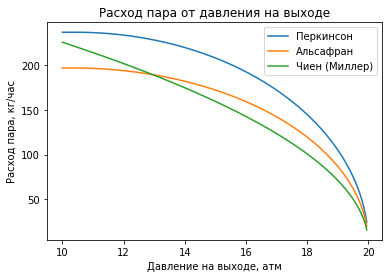

In [6]:
'Построение графика "Расход пара от давления на выходе"'
p1_atm=20
p2_a=np.arange(10,p1_atm,0.05)
q1=np.array([])
q2=np.array([])
q3=np.array([])
for p2_atm in p2_a:
    p1=wi_kghr(p1_atm, p2_atm,5)
    p2=qmix_choke_kghr(p1_atm, p2_atm,5)
    p3=wchoke_kghr(p1_atm, p2_atm,5)
    q1=np.append(q1,p1)
    q2=np.append(q2,p2)
    q3=np.append(q3,p3)
plt.plot(p2_a,q1,label='Перкинсон') 
plt.plot(p2_a,q2,label='Альсафран')
plt.plot(p2_a,q3,label='Чиен (Миллер)')
plt.title('Расход пара от давления на выходе')
plt.ylabel('Расход пара, кг/час')
plt.xlabel('Давление на выходе, атм')
plt.legend()
plt.show()